In [1]:
cd AdversarialRendering/

/home/dcor/niskhizov/AdversarialRendering


In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
from peft import LoraConfig, get_peft_model


In [3]:
import sys

In [4]:
sys.path.append('/home/dcor/niskhizov/dinov2')

In [5]:
from dinov2.models.vision_transformer import vit_small

/home/dcor/niskhizov/dinov2/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/dcor/niskhizov/dinov2/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/dcor/niskhizov/dinov2/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [87]:
import torchvision
resizer = torchvision.transforms.Resize((224, 448))
unresizer = torchvision.transforms.Resize((480, 640))

In [2]:
unet = models.segmentation.deeplabv3_resnet50(pretrained=True)

In [3]:
unet.classifier[4] = nn.Conv2d(256, 3, kernel_size=1)

In [4]:
unet.backbone.conv1

In [9]:
# unet.backbone.layer4

In [ ]:
# config = LoraConfig(
#     r=8,  # Low-rank parameter
#     lora_alpha=16,
#     lora_dropout=0.05,
#     target_modules=["conv1"]  # Apply LoRA to deeper layers
# )

# unet = get_peft_model(unet, config)

In [46]:
dinov2_vitbs14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14").cuda()

Using cache found in /home/dcor/niskhizov/cache/hub/facebookresearch_dinov2_main
INFO:dinov2:using MLP layer as FFN


In [48]:
with torch.no_grad():
    o = dinov2_vitbs14.forward_features(resizer(anchor.cuda()))

In [52]:
o['x_norm_patchtokens'].shape

torch.Size([8, 512, 384])

In [100]:
# Load DINOv2-Small (ViT-S/14)
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
dinov2_vits14.eval()  # Set to evaluation mode (no training)

class DINOv2Img2Img(nn.Module):
    def __init__(self, num_output_channels=3):
        super(DINOv2Img2Img, self).__init__()

        self.backbone = dinov2_vits14  # Pretrained DINOv2 model (frozen)
        
        # Decoder: Converts DINOv2 features into an image
        self.decoder = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),  # DINOv2-S output has 384 channels
            nn.ReLU(),
            nn.Conv2d(256, num_output_channels, kernel_size=1),
            nn.Sigmoid()  # Ensures output is in range 0-1
        )

    def forward(self, x):
        x_tmp = resizer(x)
        with torch.no_grad():  # Don't train DINOv2 backbone
            features = self.backbone.forward_features(x_tmp)  # Extract high-level features
            features = features["x_norm_patchtokens"]  # Use normalized patch tokens
            # print(features.shape)
            features = features.permute(0, 2, 1).view(x_tmp.shape[0], 384, 32, 16)  # Reshape

        output = self.decoder(features)  # Convert features to image
        # print(output.shape)
        output = nn.functional.interpolate(output, size=(512, 512), mode="bilinear", align_corners=False)  # Upsample
        return x + unresizer(output)  # Output image in range [0,1]

model = DINOv2Img2Img().cuda()

Using cache found in /home/dcor/niskhizov/cache/hub/facebookresearch_dinov2_main
INFO:dinov2:using MLP layer as FFN


In [101]:
import glob
import tqdm
import matplotlib.pyplot as plt
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [102]:
projections_dir = '/home/dcor/niskhizov/projections_pairs/projections_patch6/'
patterns_dir = "/home/dcor/niskhizov/projections_pairs/rnd_patterns_patch6/"
projections = glob.glob(projections_dir + '/*')
patterns = glob.glob(patterns_dir + '/*')
# load data from calibration
import pickle
with open('/home/dcor/niskhizov/AdversarialRendering//calibration_dump/calibration2.pickle','rb') as f:
    H = pickle.load(f)
with open('/home/dcor/niskhizov/AdversarialRendering//calibration_dump/orig_ref_frame2.pickle','rb') as f:
# with open('/home/dcor/niskhizov/AdversarialRendering//calibration_dump/orig_ref_frame2.pickle','rb') as f:
    orig_ref_frame = pickle.load(f)

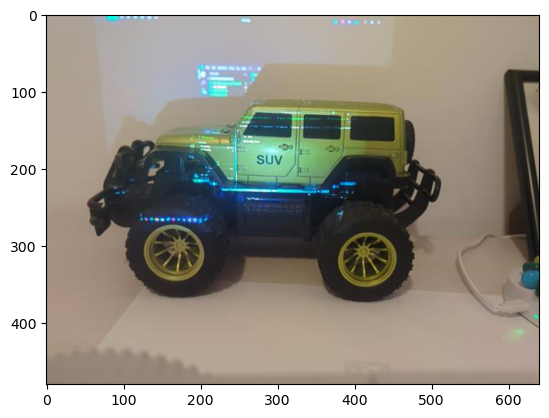

In [103]:
plt.imshow(orig_ref_frame)

In [104]:
from torchvision import transforms

tt = transforms.ToTensor()

import torch 
import kornia
H_t = torch.tensor(H).float().unsqueeze(0)
def warp(img):
    return kornia.geometry.transform.warp_perspective(img, H_t, (orig_ref_frame.shape[0], orig_ref_frame.shape[1]))

In [105]:
orig_ref_frame_tensor = tt(orig_ref_frame).unsqueeze(0)


In [106]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

tp = transforms.ToPILImage()
tt = transforms.ToTensor()

# 300 600 resize



class ImagePairDataset(Dataset):
    def __init__(self, projections, patterns, transform=None):
        self.projections = projections
        self.patterns = patterns

    def __len__(self):
        return len(self.projections)

    def __getitem__(self, idx):
       
        proj_path = self.projections[idx]

        proj_image = cv2.imread(proj_path)

        proj_image = cv2.cvtColor(proj_image, cv2.COLOR_BGR2RGB)

        proj_pattern = proj_image#[185:235,284:384,:]#[150:250,180:380,:]

        pattern_path = self.patterns[idx]

        pattern = cv2.imread(pattern_path)#.transpose(1, 0, 2)

        proj_pattern = tt(proj_pattern)
        pattern = tt(pattern).unsqueeze(0)


        imag_w = warp(pattern)
        mask_w = warp(pattern*0+1)

        sum_tensor =  ((mask_w != 0) * -0.5 + 1) * orig_ref_frame_tensor + imag_w * 0.5

        sum_tensor = sum_tensor[0]
        

        return sum_tensor, proj_pattern 


dataset = ImagePairDataset(projections, patterns)

In [107]:
train_size = int(0.8 * len(projections))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=8 )

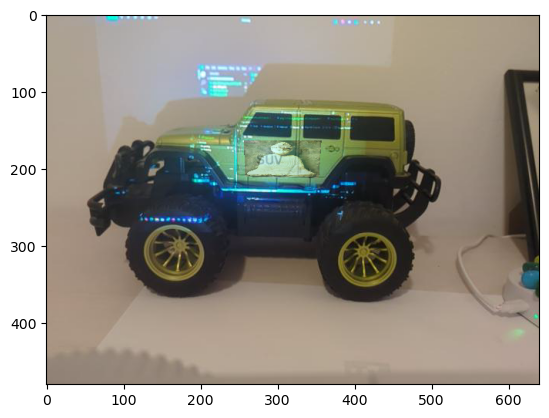

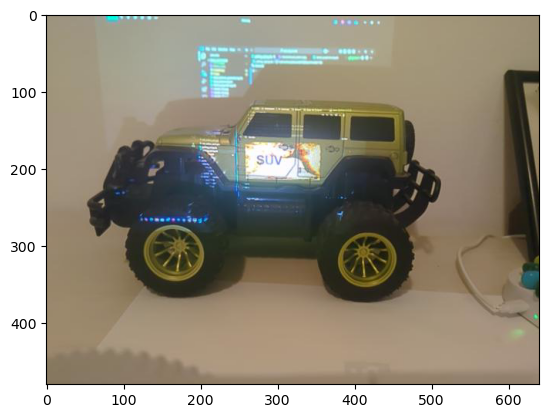

In [108]:
idx = 100
plt.imshow(dataset[idx][0].permute(1, 2, 0))
plt.show()
plt.imshow(dataset[idx][1].permute(1, 2, 0))
plt.show()

In [109]:
import tqdm

In [110]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for epoch in range(100):
    for idx,(anchor, target) in tqdm.tqdm(enumerate(train_dataloader)):  # Load (anchor image, modified target)
        anchor, target = anchor.cuda(), target.cuda()
        
        optimizer.zero_grad()
        pred = model(anchor)
        
        loss = nn.L1Loss()(pred, target)  # Use L1 loss since most pixels remain unchanged
        loss.backward()
        optimizer.step()

        if idx % 100 == 0:
    
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
            plt.imshow(pred[0].detach().cpu().numpy().transpose(1, 2, 0))
            plt.show()
            plt.imshow(target[0].detach().cpu().numpy().transpose(1, 2, 0))
            plt.show()
            plt.imshow(anchor[0].detach().cpu().numpy().transpose(1, 2, 0))
            plt.show()
            


In [84]:
# save the model
torch.save(model.state_dict(), 'lora_mobile_unet4.pth')

In [85]:
pwd

In [ ]:
pred = model(anchor)

In [ ]:
anchor.shape

In [ ]:
plt.imshow(anchor[0].detach().cpu().numpy().transpose(1, 2, 0))